# Hit classification

Set initial variables for the "suffix" identifier for the data set and "filePath" the relative path to the data files. Remember to add "/" to the end of your path, for example "../../TrkAna/43291981/"

In this notebook we use Keras and XGBoost to distinguish between hits from conversion electrons and hits from other particles

In [1]:
import os
import uproot 
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tensorflow as tf
from pathlib import Path
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, ReLU
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.layers
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from xgboost import XGBClassifier
import onnx
import tf2onnx

2024-09-18 16:57:49.793907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
rm -rf ./logs/

In our problem we have a different number of signal and background entries in our input dataset. There are several techniques avaialable for _unbalanced_ datasets. Here we are using the most naive one, which is just using $\min(N_{sig}, N_{bkg})$ events. Then, we divide our input into the _training_, _validation_, and _test_ datasets.  Note that the datasets must be pruned to the nearest multiple of the batch size, otherwise the gradient calculation fails.

In [32]:
input_dataset = np.empty
temp = np.empty
signal = np.empty
backgnd = np.empty
#files = ["/global/cfs/cdirs/m3712/Mu2e/TA_CeEndpointMix1BBTriggerable.MDC2020ae_best_v1_3.root"]
#files = ["/global/u2/j/jasonguo/KKTrain/TADeMCeEDigis.root"]
files = ["/global/cfs/cdirs/m3712/Mu2e/TADeM_CeEndpointMix1BBTriggerable.MDC2020ae_perfect_v1_3.root"]

data_fields = ["state", "udoca", "cdrift", "rdrift", "tottdrift", "wdot", "udocavar", "wdist", "uupos", "poca"]
mc_fields = ["rel"]

a = {field: [] for field in data_fields}
for field in mc_fields:
    a[field] = []
    
for batch in uproot.iterate(files,filter_name="/trk|trktsh|trktshmc/i"):
    #print("Fields available in 'trktsh':", ak.fields(batch["trktshmc"]))
    #cut = ak.sum(batch["trk.status"],axis=1) == 1
    
    cut = ((ak.sum(batch["trk.status"],axis=1) > 0) & ak.sum(batch["trk.goodfit"],axis=1)) == 1 #& 
           #(ak.sum(batch["trktshmc"]["startCode"], axis=1) == 167)) == 1
    
    batch["trktshmc"]["startCode"].type.show()
    #cut2 = ak.flatten(ak.flatten(batch["trktshmc"]["startCode"][ak.local_index(batch["trktshmc"]["startCode"]) < ak.num(batch["trktsh"]
    #        [data_fields[0]], axis = 2)][cut])).to_numpy()
    #cut2 = (cut2 == 167)
    for field in data_fields:
        a[field].append(ak.flatten(ak.flatten(batch["trktsh"][field][cut])).to_numpy())
    for field in mc_fields:
        a[field].append(ak.flatten(ak.flatten(batch["trktshmc"][field][ak.local_index(batch["trktshmc"][field]) < ak.num(batch["trktsh"]
            [data_fields[0]], axis = 2)][cut])).to_numpy())
for field in a:
    a[field] = np.concatenate(a[field])
    
udoca = np.absolute(a["udoca"])
sint = np.sqrt(1.0-a["wdot"]*a["wdot"])
plen = 6.25-a["cdrift"]*a["cdrift"]
pmin = np.repeat(0.25,plen.shape[0])
plen = np.sqrt(np.maximum(plen,pmin))
udocasig = np.sqrt(a["udocavar"])
print(a["poca"][0][0][0])
rho = np.array([np.sqrt(np.square(x[0][0]) + np.square(x[0][1])) for x in a["poca"]])
du = np.absolute(a["wdist"] - a["uupos"])


temp = np.vstack((udoca, a["cdrift"], udocasig, a["tottdrift"], du, rho)).T
if input_dataset is np.empty:
    input_dataset = temp
else:
    input_dataset = np.concatenate((input_dataset, temp))


#print("Processed file " + filename + " with %s hits"%a['state'].shape[0])
#print(a["rel"].shape)
#print(a["state"].shape)
#print (len(a["rel"]))
#print (len(a["state"]))
mcrel = np.array([x[0] for x in a["rel"]])
rand = np.random.random_sample([mcrel.shape[0]])

#print(udoca)
sig = (a["state"]>=-2) & (rand<0.05) & (mcrel==0) & (udoca < 50.0) & (du < 3000.0)
bkg = (a["state"]>=-2) & (mcrel==-1) & (udoca < 50.0) & ( du < 3000.0)
#print (np.sum(sig))
if signal is np.empty:
    signal = sig
    backgnd = bkg
else:
    signal = np.concatenate((signal,sig))
    backgnd = np.concatenate((backgnd,bkg))
        
nhits=len(input_dataset)
nsignal=signal.sum()
nbackgnd=backgnd.sum()
print("Total dataset %s hits, %s signal and %s background"%(nhits,nsignal,nbackgnd))
    


8225 * var * var * int32
8225 * var * var * int32
8225 * var * var * int32
6061 * var * var * int32
140.59918


/tmp/ipykernel_627872/3474285997.py:40: RuntimeWarning: invalid value encountered in sqrt
  udocasig = np.sqrt(a["udocavar"])


Total dataset 1099343 hits, 52296 signal and 24988 background


In [33]:
min_len = min(len(input_dataset[signal]), len(input_dataset[backgnd]))
bsize=32
# I need to double the batch_size when truncating as we divide the sample in half later for training
tsize=2*bsize
min_len = (min_len - min_len%tsize)
print("Training on %s matched hits"%min_len)
signal_dataset = input_dataset[signal][:min_len]
bkg_dataset = input_dataset[backgnd][:min_len]

balanced_input = np.concatenate((signal_dataset, bkg_dataset))
y_balanced_input = np.concatenate((np.ones(signal_dataset.shape[0]), np.zeros(bkg_dataset.shape[0])))

n_variables = balanced_input.shape[1]

x_ce_train, x_ce_test, y_ce_train, y_ce_test = train_test_split(balanced_input, y_balanced_input, test_size=0.5, random_state=42)
x_ce_test, x_ce_valid, y_ce_test, y_ce_valid = train_test_split(x_ce_test, y_ce_test, test_size=0.5, random_state=42)

Training on 24960 matched hits


<function matplotlib.pyplot.show(close=None, block=None)>

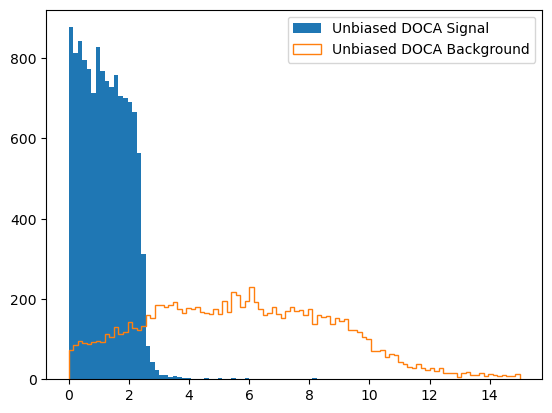

In [34]:
udoca_sig = []
udoca_back = []

for i in range(x_ce_train.shape[0]):
    if y_ce_train[i] == 1:
        udoca_sig.append(x_ce_train[i][0])
    else:
        udoca_back.append(x_ce_train[i][0])
plt.hist(udoca_sig,label="Unbiased DOCA Signal", bins=100,range=(0,15))
plt.hist(udoca_back,label="Unbiased DOCA Background", histtype='step', bins=100,range=(0,15))
plt.legend()
plt.show

In [35]:
udoca_sig = []
tottdrift_sig = []
cdrift_sig = []
udocasig_sig = []
du_sig = []
rho_sig = []

for i in range(signal_dataset.shape[0]):
    udoca_sig.append(signal_dataset[i][0])
    
for i in range(signal_dataset.shape[0]):
    cdrift_sig.append(signal_dataset[i][1])
    
for i in range(signal_dataset.shape[0]):
    udocasig_sig.append(signal_dataset[i][2])

for i in range(signal_dataset.shape[0]):
    tottdrift_sig.append(signal_dataset[i][3])

for i in range(signal_dataset.shape[0]):
    du_sig.append(signal_dataset[i][4])

for i in range(signal_dataset.shape[0]):
    rho_sig.append(signal_dataset[i][5])

In [36]:
udoca_back = []
tottdrift_back = []
cdrift_back = []
udocasig_back = []
du_back = []
rho_back = []
    
for i in range(bkg_dataset.shape[0]):
    udoca_back.append(bkg_dataset[i][0])
    
for i in range(bkg_dataset.shape[0]):
    cdrift_back.append(bkg_dataset[i][1])
    
for i in range(bkg_dataset.shape[0]):
    udocasig_back.append(bkg_dataset[i][2])

for i in range(bkg_dataset.shape[0]):
    tottdrift_back.append(bkg_dataset[i][3])
    
for i in range(bkg_dataset.shape[0]):
    du_back.append(bkg_dataset[i][4])
    
for i in range(bkg_dataset.shape[0]):
    rho_back.append(bkg_dataset[i][5])

<function matplotlib.pyplot.show(close=None, block=None)>

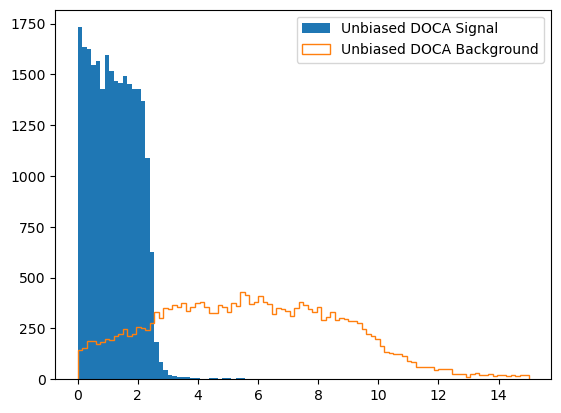

In [37]:
plt.hist(udoca_sig,label="Unbiased DOCA Signal", bins=100,range=(0,15))
plt.hist(udoca_back,label="Unbiased DOCA Background", histtype='step', bins=100,range=(0,15))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

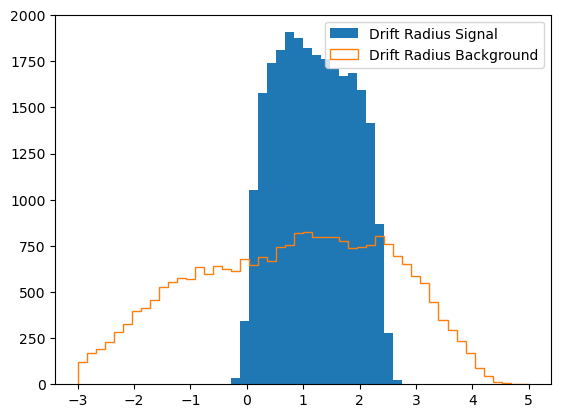

In [38]:
plt.hist(cdrift_sig,label="Drift Radius Signal", bins=50,range=(-3.0,5.0))
plt.hist(cdrift_back,label="Drift Radius Background", histtype='step', bins=50, range=(-3.0,5.0))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

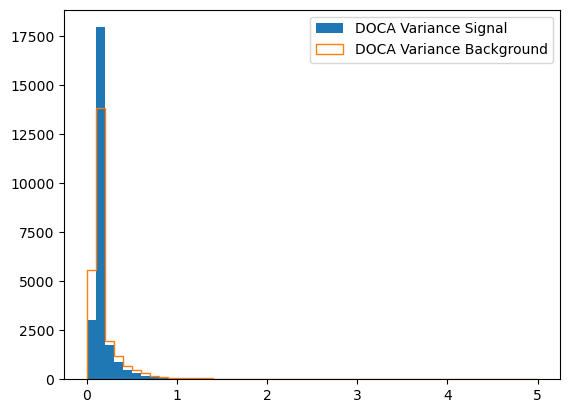

In [39]:
plt.hist(udocasig_sig,label="DOCA Variance Signal", bins=50,range=(0,5))
plt.hist(udocasig_back,label="DOCA Variance Background", histtype='step', bins=50,range=(0,5))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

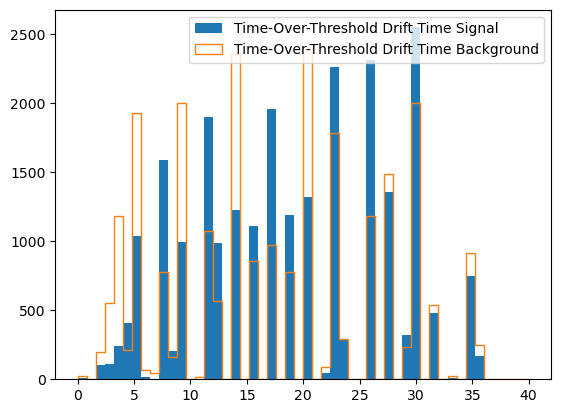

In [40]:
plt.hist(tottdrift_sig,label="Time-Over-Threshold Drift Time Signal", bins=50, range=(0,40))
plt.hist(tottdrift_back,label="Time-Over-Threshold Drift Time Background", histtype='step', bins=50,range=(0,40))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

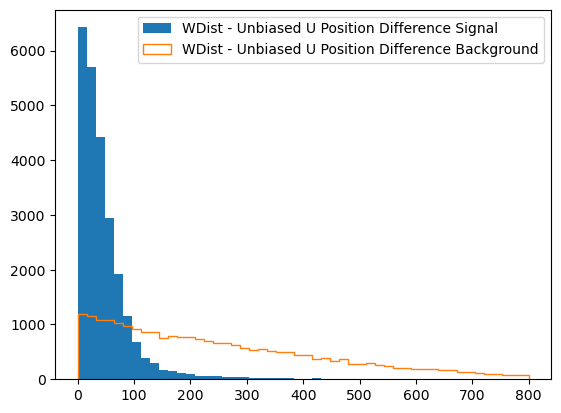

In [41]:
plt.hist(du_sig,label="WDist - Unbiased U Position Difference Signal", bins=50, range=(0,800))
plt.hist(du_back,label="WDist - Unbiased U Position Difference Background", histtype='step', bins=50, range=(0,800))
plt.legend()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

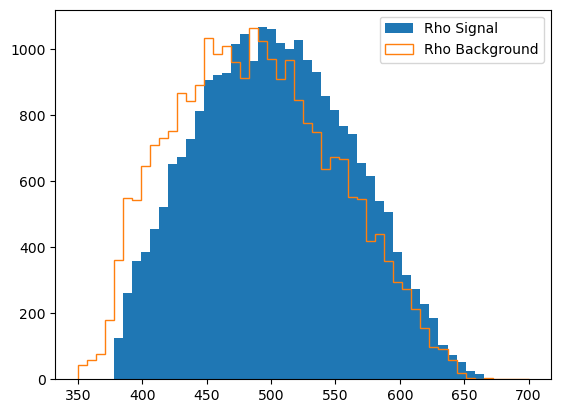

In [42]:
plt.hist(rho_sig,label="Rho Signal", bins=50, range=(350,700))
plt.hist(rho_back,label="Rho Background", histtype='step', bins=50, range=(350,700))
plt.legend()
plt.show

Then, we concatenate each hit variables into a single, large numpy array. These arrays are then stacked in a single bi-dimensional array with `np.vstack`, which will be our input dataset used for the training of the machine learning algorithms.

Here we then assign a label to each hit as _signal_ or _background_, depending on the Monte Carlo truth information. Since the dimension of  `detshmc.rel._rel` is not guaranteed to be the same as the dimension of `detsh` we need to loop over all the entries.

## Create and train a multi-layer perceptron

Here we create a _multi-layer perceptron_ (MLP) model which consists of 3 fully-connected (or _dense_) layers, each one followed by a _dropout_ layer, which helps to avoid overfitting. The model is trained using the [Adam](https://arxiv.org/abs/1412.6980) optimizer and trained for 50 epochs or until the validation loss doesn't improve for 5 epochs (`early_stop`). The model we save must be created first, with an explicit input layer with explicit batch_size, otherwise it can't be parsed by the TMVA::SOFIE parser we use to generate a C++ inference function downstream. 

The output model must have batch_size=1, otherwise the SOFIE inference function will assume that many input variables at a time.  Training (gradient calculation) however is much more efficient with a larger batch size, so we construct a separate model for that.  After training and before saving, we'll copy the weights (which don't depend on batch_size) from the trained model to the output model.  This should be unnecessary in the next verison of ROOT.

We should initialize the model by reading a previous iteration. TODO

In [43]:
# load previous training if it exists
suffix = "newdata"
modelfile = "models/TrainBkg" + suffix + ".h5"
if False:
    model = keras.models.load_model(modelfile)
    print("Loading model from file " +modelfile)
else:
    print("Creating model " +modelfile)
    lay0=Input(shape=(n_variables,),batch_size=bsize)
    lay1=Dense(2*n_variables, activation='relu')(lay0)
    lay2=Dense(2*n_variables, activation='relu')(lay1)
    lay3=Dense(2*n_variables, activation='relu')(lay2)
    lay4=Dense(1,activation='sigmoid')(lay3)
    model=Model(inputs=lay0,outputs=lay4)

opt = Adam(learning_rate=1e-3)
model.compile(loss='binary_crossentropy',metrics='accuracy',optimizer=opt)
early_stop = EarlyStopping(monitor='val_loss', patience=20, min_delta=1e-5, restore_best_weights=True)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(x_ce_train, y_ce_train,
                          batch_size=bsize,
                          epochs=200,
                          verbose=1,
                          validation_data=(x_ce_valid, y_ce_valid),
                          callbacks=[early_stop, tensorboard_callback]
                         )

Creating model models/TrainBkgnewdata.h5
Epoch 1/200
780/780 [==============================] - 2s 1ms/step - loss: 0.7143 - accuracy: 0.5058 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 2/200
780/780 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 3/200
780/780 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4964 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 4/200
780/780 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4996 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 5/200
780/780 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 6/200
780/780 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6931 - val_accuracy: 0.5023
Epoch 7/200
780/780 [==============================] - 1s 1ms/step - loss: 0.6932 - accuracy: 0.4988 

KeyboardInterrupt: 

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

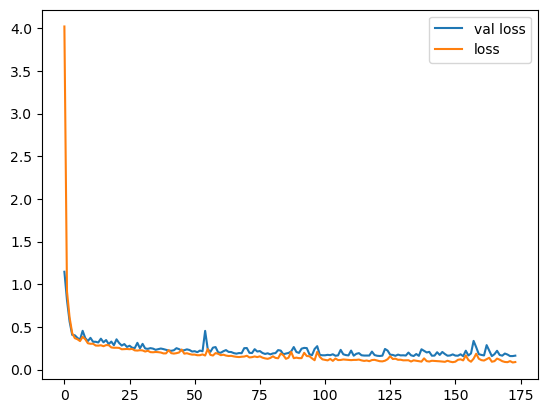

In [194]:
plt.plot(history.history['val_loss'],label="val loss")
plt.plot(history.history['loss'],label="loss")
plt.legend()

%load_ext tensorboard
#rm -rf ./logs/
%tensorboard --logdir logs/fit

## Create and train a Boosted Decision Tree
Here, instead of using a MLP, we use a [_Gradient Boosted Decision Tree_](https://xgboost.readthedocs.io/en/stable/) (BDT) to distinguish between signal (true CE hits) and background (fake CE hits). We use the defualt hyperparameters.

In [195]:
model_xgboost = XGBClassifier(use_label_encoder=False)
model_xgboost.fit(x_ce_train, y_ce_train)

/global/homes/j/jasonguo/.conda/envs/KKTrain2/lib/python3.9/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

Here we can finally apply our two models (the MLP and the BDT) to our test datasets and create the corresponding ROC curves.

In [196]:
#prediction_ce = model.predict(x_ce_test).ravel()
prediction_ce = model.predict(x_ce_test)
fpr_ce, tpr_ce, th_ce = roc_curve(y_ce_test,  prediction_ce)
auc_ce = roc_auc_score(y_ce_test, prediction_ce)

12/12 [==============================] - 0s 789us/step


In [197]:
prediction_xgboost = model_xgboost.predict_proba(x_ce_test)[:,1]
fpr_xgboost, tpr_xgboost, th_xgboost = roc_curve(y_ce_test,  prediction_xgboost)
auc_xgboost = roc_auc_score(y_ce_test, prediction_xgboost)

The plot of the ROC curves clearly shows that the BDT outperforms the MLP. In principle, however, it should be possible to improve the MLP performances by optimizing the hyperparameters (learning rate, hidden layers, activation functions, etc.).

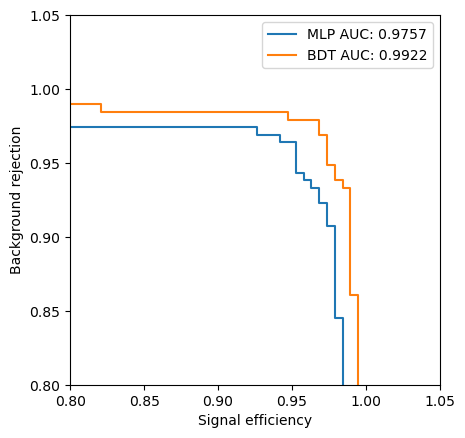

In [199]:
fig, ax = plt.subplots(1,1)
ax.plot(tpr_ce,1-fpr_ce,label=f'MLP AUC: {auc_ce:.4f}')
ax.plot(tpr_xgboost,1-fpr_xgboost,label=f'BDT AUC: {auc_xgboost:.4f}')

ax.legend()
ax.set_aspect("equal")
ax.set_xlabel("Signal efficiency")
ax.set_ylabel("Background rejection")
ax.set_xlim(0.8,1.05)
ax.set_ylim(0.8,1.05)

fig.savefig("plots/TrainBkg" + suffix + ".pdf")

Now we save our model in HDF5 format.  This can be used as input to the SOFIE parser.  Note that the kernel must be restarted when saving this file, as re-running individual cells increments the layer numbers in the hdf5 file, causing the SOFIE parser to fail.  This causes the spurious tensorflow warning about the model not having been built.

In [200]:
model.save(modelfile)
print("model saved to " +modelfile)
model.summary()

model saved to models/TrainBkgnewdata.h5
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(32, 6)]                 0         
                                                                 
 dense (Dense)               (32, 12)                  84        
                                                                 
 dense_1 (Dense)             (32, 12)                  156       
                                                                 
 dense_2 (Dense)             (32, 12)                  156       
                                                                 
 dense_3 (Dense)             (32, 1)                   13        
                                                                 
Total params: 409
Trainable params: 409
Non-trainable params: 0
_________________________________________________________________
